In [1]:
import numpy as np
import struct
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_ubyte(file_name, img_file=True):
    data = None
    if img_file:
        with open(file_name, 'rb') as f:
            magic, size = struct.unpack('>II', f.read(8))
            nrows, ncols = struct.unpack('>II', f.read(8))
            data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
            data = data.reshape((size, nrows * ncols))
    else:
        with open(file_name, 'rb') as f:
            magic, size = struct.unpack('>II', f.read(8))
            data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    return data

### Data loading

In [3]:
train_indices = np.random.randint(0, 60000, size=2000)
test_indices = np.random.randint(0, 10000, size=1000)
X_train = read_ubyte('./dataset/train-images-idx3-ubyte')[train_indices]
y_train = read_ubyte('./dataset/train-labels-idx1-ubyte', img_file=False)[train_indices]
X_test = read_ubyte('./dataset/t10k-images-idx3-ubyte')[test_indices]
y_test = read_ubyte('./dataset/t10k-labels-idx1-ubyte', img_file=False)[test_indices]

In [4]:
print('Training data:', X_train.shape, y_train.shape)
print('Testing data:', X_test.shape, y_test.shape)

Training data: (2000, 784) (2000,)
Testing data: (1000, 784) (1000,)


#### Visualize a random sample

Sample #1456: 1


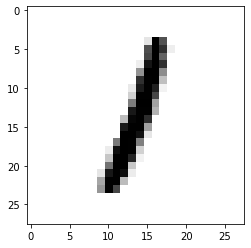

In [5]:
rnd_idx = np.random.randint(0, X_train.shape[0])
sample_img, sample_label = X_train[rnd_idx], y_train[rnd_idx]

import matplotlib.pyplot as plt
print('Sample #{id}: {label}'.format(id=rnd_idx, label=sample_label))
plt.imshow(sample_img.reshape(28, 28), cmap='binary');

In [6]:
def plot_samples(new_data, data=None):
    """
    Plot multiple images on grid
    """
    nimgs = new_data.shape[0] + new_data.shape[0] * (data is not None)
    ncols = 10
    nrows = (nimgs + ncols - 1) // ncols
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(min(ncols * 1.25, 10), 4),
                           subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    i = j = k = 0
    while k < nimgs:
        ax.flat[k].imshow(new_data[i].reshape(28, 28), cmap='binary').set_clim(0, 16)
        i += 1
        k += 1
        if data is not None:
            ax.flat[k].imshow(data[j].reshape(28, 28), cmap='binary').set_clim(0, 16)
            j += 1
            k += 1

### Kernel Density Implementation

Formula used in `score_sample`:

$\log{p(x)} =
\log \sum_{i=1}^{n} \exp{\frac{1}{n}} +
\sum_{j=1}^{d} [-\frac{x_j - \mu_{i, j}}{2 \sigma^2} - \frac{1}{2} \log(2 \pi \sigma^2)]$

Formula used in `score`

$\mathcal{L}_{\mathcal{D}_{\mathcal{B}}} = \sum_{i=1}^{m}\log{p(x_{i}^\mathcal{B})}$

In [8]:
from sklearn.neighbors import KDTree, BallTree
from sklearn.base import BaseEstimator
from scipy.special import gammainc

VALID_KERNELS = ['gaussian', 'tophat']
VALID_ALGORITHMS = ['kd_tree', 'ball_tree', 'brute_force']

class KernelDensity(BaseEstimator):
    
    def __init__(self, bandwidth=1, kernel='gaussian', algorithm='kd_tree'):
        assert kernel in VALID_KERNELS
        assert algorithm in VALID_ALGORITHMS
        
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.algorithm = algorithm
        
    def fit(self, X, sample_weight=None):
        self.data_ = X
        if self.algorithm == 'kd_tree':
            self.tree_ = KDTree(X, metric='euclidean')
        elif self.algorithm == 'ball_tree':
            self.tree_ = BallTree(X, metric='euclidean')
        return self
    
    def update_bandwidth(self):
        N, D = self.data_.shape[0], self.data_[0].shape[0]
        if np.isscalar(self.bandwidth) and not isinstance(self.bandwidth, str):
            return self.bandwidth
        elif self.bandwidth in ['auto', 'scott']:
            return 1.06 * np.std(self.data_, axis=0) * N ** (-1 / (D + 4))
    
    def score_samples(self, X):
        N, D = self.data_.shape[0], self.data_[0].shape[0]
        if hasattr(self, 'tree_'):
            log_density = self.tree_.kernel_density(X, h=self.bandwidth,
                                                    kernel=self.kernel, return_log=True)
        elif self.algorithm == 'brute_force':
            sum_density = np.subtract(self.data_, X[:, np.newaxis]) ** 2
            sum_density = -np.sum(sum_density, axis=2)
            sum_density = np.sum(np.exp(sum_density / (2 * self.bandwidth ** 2)), axis=1)
            log_density = -0.5 * D * np.log(2 * np.pi * self.bandwidth ** 2) + np.log(sum_density)
        
        return log_density - np.log(N)
    
    def score(self, X, y=None):
        return np.sum(self.score_samples(X)) 
    
    def sample(self, n_samples=1, random_state=None):
        N, D = self.data_.shape[0], self.data_[0].shape[0]
        rng = np.random.RandomState(random_state)
        indices = rng.choice(N, n_samples)
        
        if self.kernel == 'gaussian':
            return np.atleast_2d(rng.normal(self.data_[indices], self.bandwidth))
        
        elif self.kernel == 'tophat':
            # Draw points from a D-dimensional normal distribution
            # Then, use incomplete gamma function to map them to
            # a D-dimensional uniform tophat distribution
            
            X = rng.normal(size=(n_samples, D))
            norm_X = np.sqrt(np.sum(X * X, axis=1))
            correction = (gammainc(0.5 * D, 0.5 * norm_X) ** (1. / D))
            correction *= self.bandwidth / np.sqrt(norm_X)
            return self.data_[indices] + X * correction[:, np.newaxis]
        
        raise NotImplementedError()
 

### Bandwidth Estimator using Cross-validation

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

def estimate_bandwidth(X, range_bw=np.logspace(-1, 1, 10), cv=5):
    params = {'bandwidth': range_bw}
    grid = GridSearchCV(KernelDensity(), param_grid=params, cv=cv).fit(X);
    return grid.best_estimator_.bandwidth

### Generate new samples using generative Kernel Density

In [10]:
bandwidth = estimate_bandwidth(X_train, range_bw=np.linspace(30, 40, 10))
kde = KernelDensity(bandwidth=bandwidth, kernel='tophat').fit(X_train)

Bandwidth: 37.77777777777778


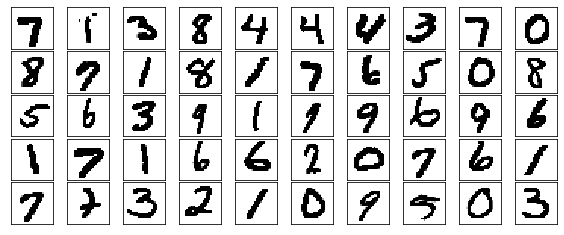

In [11]:
print('Bandwidth:', bandwidth)
new_digits = kde.sample(50)
plot_samples(new_digits)